In [2]:
import opensimplex
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint
import os
import multiprocessing as mp
import plotly.express as px
from random import randint, random, uniform

biomas = np.empty(shape=(128,128,128), dtype=np.uint8)
for i in range(128):
    for j in range(128):
        for k in range(128):
            mejor = float('inf')
            for r in generator.BIOMAS.keys():
                a = np.linalg.norm(np.array(generator.BIOMAS[r][0]) - np.array([i/128, j/128, k/128]))
                if a < mejor:
                    mejor = a
                    biomas[i, j, k] = r
    print(i)
print(biomas)
np.save(f"CERCANIA_BIOMAS.npy", biomas)


In [50]:
class generator:
    #(Humedad altura temperatura), nombre del bioma, color, {objetos que pueden aparecer, probabilidades}
    BIOMAS = {
        0: ([-1, -1, -1], 'Oceano', (56, 148, 194), {}, ),
        1: ([-1, -1, -1], 'Oceano profundo', (27, 59, 140), {}),
        2: ([-1, -1, -1], 'Rios y lagos', (126, 180, 237), {}),
        3: ([0.5, 0.0, 0.5], 'Costa', (245, 240, 108), {"Palmera": 0.7, "Piedra pequeña": 0.3}),
        4: ([0.85, 0.05, 0.45], 'Marismas', (171, 222, 32), {"Arbusto": 1}),
        5: ([0.75, 0.1, 0.05], 'Polo', (250, 250, 250), {"Tempano": 0.5, "Piedra congelada": 0.5}),
        6: ([0.8, 0.15, 0.45], 'Pantano', (33, 133, 99), {"Arbusto": 0.2, "Piedra pequeña": 0.2, "Arbol": 0.6}),
        7: ([0.5, 0.2, 0.5], 'Bosque', (53, 118, 43), {"Arbol": 0.6, "Arbusto": 0.2, "Flores": 0.2}),
        8: ([0.6, 0.2, 0.55], 'Selva', (0, 183, 10), {"Arbol": 0.7, "Helecho": 0.3}),
        9: ([0.35, 0.2, 0.55], 'Dehesa', (128, 179, 30), {"Arbol": 0.5, "Arbusto": 0.5}),
        10: ([0.2, 0.2, 0.6], 'Savana', (228, 125, 28), {"Arbol": 0.3, "Arbusto": 0.7}),
        12: ([0.75, 0.25, 0.75], 'Termales', (39, 156, 121), {"Geiser": 0.5, "Piedra pequeña": 0.5}),
        11: ([0.0, 0.3, 0.8], 'Desierto', (255, 211, 29), {"Cactus": 0.7, "Arbusto muerto": 0.3}),
        13: ([0.4, 0.4, 0.4], 'Valle', (144, 219, 148), {"Arbol": 0.8, "Arbusto": 0.2}),
        14: ([0.2, 0.65, 0.55], 'Meseta', (110, 88, 66), {"Roca grande": 0.1, "Arbusto": 0.5, "Roca pequeña": 0.4}),
        15: ([0.7, 0.8, 0.2], 'Tundra', (208, 208, 240), {"Piedra pequeña": 0.5, "Flores": 0.5}),
        16: ([0.15, 0.8, 0.85], 'Volcanico', (159, 16, 16), {"Arbol carbonizado": 0.6, "Charco de lava": 0.4}),
        17: ([0.35, 9, 0.35], 'Montaña', (125, 125, 125), {"Roca grande": 0.3, "Roca pequeña": 0.7}),
    }
    CHUNK_SIZE = 64
    CERCANIA_BIOMAS = np.load("./CERCANIA_BIOMAS.npy" )

    def __init__(self, seedTemp = None, seedAltu = None, seedHume = None, seedRios = None):
        self.SEEDTEMP = seedTemp if seedTemp != None else randint(-2**30, 2**30)
        self.SEEDALTU = seedAltu if seedTemp != None else randint(-2**30, 2**30)
        self.SEEDHUME = seedHume if seedTemp != None else randint(-2**30, 2**30)
        self.SEEDRIOS = seedRios if seedTemp != None else randint(-2**30, 2**30)

    def getNoise(self, seed: int, x_in: int, y_in: int, iterations: int, size: int, disparity: int = 3) -> float:
        """
        Generates Perlin noise based on the given parameters.
        Args:
            seed (int): The seed value for the noise generation.
            x_in (int): The x-coordinate input for the noise function.
            y_in (int): The y-coordinate input for the noise function.
            iterations (int): The number of iterations to perform for noise generation.
            size (int): The size parameter that affects the noise scale.
            disparity (int, optional): The number of disparity adjustments to apply. Default is 3.
        Returns:
            float: The generated noise value, normalized between 0 and 1.
        """
        opensimplex.seed(seed)
        ruido = 0
        for r in range(iterations):
            divisor = (size/2**r)
            exponenciador = (2**r)
            ruido += opensimplex.noise2(x=(x_in)/divisor, y=(y_in)/divisor)/exponenciador
            
        maximo = sum([2/(2**r) for r in range(iterations)])
        ruido = (ruido + maximo)/(2*maximo)     
        for r in range(disparity):
            ruido = 0.5 + math.sin(math.pi*ruido - math.pi/2)/2
        return ruido

    def getNoiseArray(self, seed: int, x_in: int, y_in: int, iterations: int, size: int, disparity: int = 3) -> np.ndarray:
        """
        Generates a 2D noise array using OpenSimplex noise with multi-level detail and smoothing.

        Args:
            seed (int): The seed used to initialize the noise generation.
            x_in (int): The x-coordinate index for the chunk, which determines the chunk's location in the noise grid.
            y_in (int): The y-coordinate index for the chunk, which determines the chunk's location in the noise grid.
            iterations (int): The number of levels of detail or layers to add to the noise. Higher values create more detailed noise.
            size (int): The scale factor for the noise. Larger values make the noise features larger.
            disparity (int, optional): The number of smoothing iterations applied to the generated noise values. Defaults to 3.

        Returns:
            np.ndarray: A 2D array of floats representing the generated noise values, normalized and smoothed.

        Details:
            1. The noise is generated using the OpenSimplex algorithm. For each iteration, the noise is calculated at different scales 
            and added to the `noise_array` with decreasing impact for each iteration.
            2. The noise values are normalized based on the maximum possible summed noise value across all iterations.
            3. After generating the noise, the function applies sinusoidal smoothing multiple times (based on the `disparity` value) to 
            create smoother transitions in the noise.
            4. The output is a chunk of noise, determined by the size of the chunk (`self.CHUNK_SIZE`) and its position (`x_in`, `y_in`).

        Example:
            noise = getNoiseArray(seed=42, x_in=1, y_in=2, iterations=4, size=100, disparity=3)
        """
        x = self.CHUNK_SIZE*x_in
        y = self.CHUNK_SIZE*y_in
        opensimplex.seed(seed)

        rango = range(0,self.CHUNK_SIZE)
        noise_array = np.zeros(dtype=float, shape=(self.CHUNK_SIZE, self.CHUNK_SIZE))

        for r in range(iterations):
            divisor = (size/2**r)
            exponenciador = (2**r)
            for i in rango:
                for j in rango:
                    noise_array[j, i] += opensimplex.noise2(x=(i+x)/divisor, y=(y+j)/divisor)/exponenciador
        
        maximo = sum([2/(2**r) for r in range(iterations)])
        for i in rango:
            for j in rango:
                valor = (noise_array[j, i] + maximo)/(2*maximo)     
                for r in range(disparity):
                    valor = 0.5 + math.sin(math.pi*valor - math.pi/2)/2
                noise_array[j, i] = valor
        return noise_array
    
    def getBioma(self, temp, altu, hume, rios) -> np.uint8:
        """
        Determines the biome type based on temperature, altitude, and humidity.

        Args:
            temp (float): The temperature value, expected to be in the range [0, 1].
            altu (float): The altitude value, expected to be in the range [0, 1].
            hume (float): The humidity value, expected to be in the range [0, 1].

        Returns:
            int: An integer representing the biome type.
                 0 - Ocean
                 1 - Deep Ocean
                 Other values are determined by the CERCANIA_BIOMAS lookup table.
        """
        if(altu < 0.5):
            if (altu <= 0.4):
                return 1 #Oceano profundo
            else:
                return 0 #Oceano
        elif(0.45 < rios < 0.55):
            return 2 #Rios y lagos
        else:
            alt = math.floor(128*(altu-0.5)*2)
            temp = math.floor(128*temp)
            hum = math.floor(128*hume)
            return np.uint8(self.CERCANIA_BIOMAS[hum, alt, temp])

    def getChunk(self, x: int, y: int) -> np.ndarray:
        """
        Retrieves or generates a chunk of terrain data based on the given coordinates.

        If the chunk data already exists in the specified file path, it loads and returns the data.
        Otherwise, it generates new terrain data using Perlin noise, saves it to the file path, and returns the generated data.

        Parameters:
        x (int): The x-coordinate of the chunk.
        y (int): The y-coordinate of the chunk.

        Returns:
        numpy.ndarray: A 2D array representing the terrain data for the specified chunk.
        """
        if os.path.exists(f"./Chunks/T_{self.SEEDTEMP}A_{self.SEEDTEMP}H_{self.SEEDTEMP}/{x}/{y}.npy"):
            return np.load(f"./Chunks/T_{self.SEEDTEMP}A_{self.SEEDTEMP}H_{self.SEEDTEMP}/{x}/{y}.npy")
        else:
            temp = self.getNoiseArray(self.SEEDTEMP, x, y, 3, 256, 2)
            altu = self.getNoiseArray(self.SEEDALTU, x, y, 6, 512, 4)
            hume = self.getNoiseArray(self.SEEDHUME, x, y, 3, 512, 2)
            rios = self.getNoiseArray(self.SEEDRIOS, x, y, 3, 128, 4)
            array_biomas = np.zeros(dtype=np.uint8, shape=(self.CHUNK_SIZE,self.CHUNK_SIZE))

            for i in range(self.CHUNK_SIZE):
                for j in range(self.CHUNK_SIZE):
                    array_biomas[i, j] = self.getBioma(hume[i, j], altu[i, j], temp[i, j], rios[i, j])
            os.makedirs(f"./Chunks/T_{self.SEEDTEMP}A_{self.SEEDTEMP}H_{self.SEEDTEMP}/{x}", exist_ok=True)
            np.save(f"./Chunks/T_{self.SEEDTEMP}A_{self.SEEDTEMP}H_{self.SEEDTEMP}/{x}/{y}", array_biomas)
            return array_biomas
    
    def getChunksInRange(self, x_range: tuple[int, int], y_range: tuple[int, int]) -> np.ndarray:
        """
        Generates a 2D array of chunks within the specified x and y ranges.
        This method creates and starts multiple processes to generate chunks in parallel,
        then joins the processes and combines the resulting chunks into a single 2D array.
        Args:
            x_range (tuple[int, int]): A tuple specifying the start and end of the x range.
            y_range (tuple[int, int]): A tuple specifying the start and end of the y range.
        Returns:
            numpy.ndarray: A 2D array containing the combined chunks.
        """
        arr = None
        for i in range(x_range[0], x_range[1]):
            arr_proc = []
            for j in range(y_range[0], y_range[1]):
                arr_proc.append(mp.Process(target=self.getChunk, args=(i, j)))
                arr_proc[-1].start()
            for proc in arr_proc:
                proc.join()

            arr_line = None
            for j in range(y_range[0], y_range[1]):
                if arr_line is None:
                    arr_line = self.getChunk(i, j)
                else:
                    arr_line = np.vstack((arr_line, self.getChunk(i, j)))

            if arr is None:
                arr = arr_line
            else:
                arr = np.hstack((arr, arr_line))
        return arr

    def representation(self, x_range: tuple[int, int], y_range: tuple[int, int]) -> None:
        """
        Generates a visual representation of the terrain based on Perlin noise.
        Args:
            x_range (tuple[int, int]): The range of x-coordinates to generate the terrain for.
            y_range (tuple[int, int]): The range of y-coordinates to generate the terrain for.
        The function performs the following steps:
        1. Retrieves the terrain chunks within the specified x and y ranges.
        2. Initializes an empty array to store the RGB values of the terrain.
        3. Iterates through the terrain chunks and assigns the corresponding RGB values from the BIOMAS dictionary.
        4. Creates an image of the terrain using Plotly's imshow function.
        5. Adjusts the figure size to match the dimensions of the terrain array.
        6. Adds a legend to the figure, representing different biomes with their respective colors.
        7. Displays the figure.
        8. Returns the RGB array of the terrain.
        """
        arr = self.getChunksInRange(x_range, y_range)
        color_arr = np.zeros((arr.shape[0], arr.shape[1], 3), dtype=np.uint8)

        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                color_arr[i, j] = generator.BIOMAS[arr[i, j]][2]
        
        fig = px.imshow(color_arr)
        # Adjust the figure size here, considering the legend size
        fig.update_layout(
            width=arr.shape[1] + 300,  # Add extra width for the legend
            height=arr.shape[0] + 300  # Add extra height for the legend
        )

        # Add legend
        legend_items = []
        for key, value in generator.BIOMAS.items():
            legend_items.append(
                dict(
                    name=value[1],
                    marker=dict(color=f"rgb{value[2]}", size=20),
                    mode='markers',
                    type='scatter',
                    x=[None],
                    y=[None]
                )
            )
        fig.add_traces(legend_items)
        fig.show()
    
    def poisson_disc_sampling(self, radius: int, k: int) -> np.ndarray:
        """
        Generates a 2D grid of points using Poisson-disc sampling.

        Parameters:
        width (int): The width of the grid.
        height (int): The height of the grid.
        radius (float): The minimum distance between points.
        k (int): The number of attempts to generate a valid point around an existing point.

        Returns:
        numpy.ndarray: A 2D numpy array where cells with a point are marked with 1, and empty cells are marked with 0.

        Notes:
        - The algorithm uses a grid to keep track of points and their neighbors.
        - The grid cells are sized such that each cell can contain at most one point.
        - The algorithm starts with a random initial point and iteratively generates new points around active points.
        - If a valid point is found within the specified number of attempts, it is added to the list of points and marked as active.
        - If no valid point is found, the active point is removed from the list.
        """
        GRID_SIZE = int(radius / math.sqrt(2))
        columnas, filas = self.CHUNK_SIZE // GRID_SIZE, self.CHUNK_SIZE // GRID_SIZE

        def generate_point_around(point):
            r = radius * (random() + 1)
            angle = 2 * math.pi * random()
            new_x = point[0] + r * math.cos(angle)
            new_y = point[1] + r * math.sin(angle)
            return new_x, new_y

        def in_bounds(point):
            return 0 <= point[0] < self.CHUNK_SIZE and 0 <= point[1] < self.CHUNK_SIZE

        def fits(point):
            col = int(point[0] / GRID_SIZE)
            row = int(point[1] / GRID_SIZE)
            for i in range(max(col - 2, 0), min(col + 3, columnas)):
                for j in range(max(row - 2, 0), min(row + 3, filas)):
                    neighbor = grid[i, j]
                    if neighbor is not None and np.hypot(point[0] - neighbor[0], point[1] - neighbor[1]) < radius:
                        return False
            return True

        def restart_simulation(start_point):
            nonlocal grid, active, points
            grid = np.empty((columnas, filas), dtype=object)
            points = [start_point]
            active = [start_point]
            col = int(start_point[0] / GRID_SIZE)
            row = int(start_point[1] / GRID_SIZE)
            grid[col, row] = start_point

        # Create a grid to store points
        grid = np.zeros((columnas, filas), dtype=object)

        # List to store active points
        active = []
        points = []

        # Initialize with a random point
        initial_point = (uniform(0, self.CHUNK_SIZE), uniform(0, self.CHUNK_SIZE))
        restart_simulation(initial_point)

        # Main loop
        while active:
            rand_index = randint(0, len(active) - 1)
            point = active[rand_index]
            found = False

            for _ in range(k):
                new_point = generate_point_around(point)
                if in_bounds(new_point) and fits(new_point):
                    points.append(new_point)
                    active.append(new_point)
                    col = int(new_point[0] / GRID_SIZE)
                    row = int(new_point[1] / GRID_SIZE)
                    grid[col, row] = new_point
                    found = True
                    break

            if not found:
                active.pop(rand_index)
                # Create a 2D numpy array representation
        matrix = np.zeros((self.CHUNK_SIZE, self.CHUNK_SIZE), dtype=np.uint8)
        for p in points:
            x, y = int(p[0]), int(p[1])
            matrix[y, x] = 1

        return matrix


In [51]:
a = generator(1,2,3,4)

In [52]:
a.representation((0,16),(0,16))

In [5]:
a = generator(1,2,3)
b = a.getChunk(0,0)
b_noise_Temp = a.getNoiseArray(1, 0, 0, 5, 128, 2)
b_noise_Altu = a.getNoiseArray(2, 0, 0, 3, 512, 4)
b_noise_Hume = a.getNoiseArray(3, 0, 0, 3, 256, 2)

In [185]:
resultado = a.poisson_disc_sampling(2,10)
for r in resultado:
    print("".join([str("🌲" if j==1 else "🟫") for j in list(r.flatten())][0:64]))

🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🌲🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🟫
🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫
🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🌲🟫🌲🟫🟫🌲🟫🟫🌲🟫🟫🌲🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫
🌲🟫🌲🟫🌲🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🌲🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🌲
🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🌲🟫🟫🟫🟫🌲🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫🟫🟫🟫🌲🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫
🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🌲🟫🟫🌲🟫🟫🟫🟫🌲🟫🌲🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🌲🟫
🌲🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🌲🟫🌲🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫
🟫🟫🟫🌲🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🌲🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🌲🟫🟫
🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🌲🟫🌲🟫🟫🌲🟫🟫🟫🟫🌲🟫🌲🟫🌲🟫🌲🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🌲🟫🟫
🟫🟫🌲🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🌲🟫🟫🌲🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫
🌲🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🌲🟫🟫🌲🟫🌲🟫🌲🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🌲🟫🌲🟫🟫🟫🌲
🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🟫🟫🟫🟫🟫🌲🟫🟫🌲🟫🟫

In [164]:
gtr = a.getFractalNoiseArray(123,34,7,4,16,3)
print(gtr)

[[0.00083511 0.00100262 0.00152401 ... 0.00072446 0.00132693 0.00284349]
 [0.00127895 0.00193673 0.00222237 ... 0.00065001 0.00119148 0.0034454 ]
 [0.00188962 0.0029825  0.00283211 ... 0.00064732 0.00154927 0.00407253]
 ...
 [0.00190146 0.00134237 0.00083732 ... 0.20210423 0.1821459  0.10127136]
 [0.00264083 0.00228841 0.0016737  ... 0.1914461  0.14352661 0.07405585]
 [0.00324761 0.00336357 0.00395281 ... 0.14387918 0.09265979 0.04945236]]


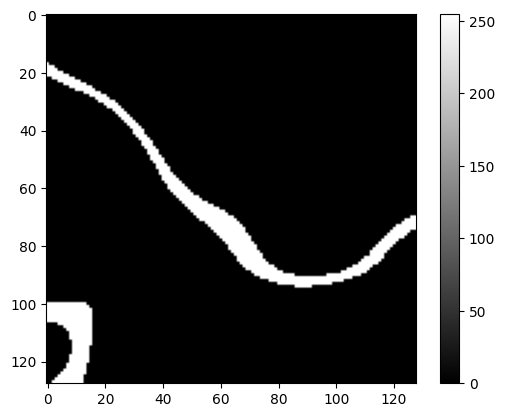

In [30]:
CHUNK_SIZE = 128
def getNoiseArray( seed: int, x_in: int, y_in: int, iterations: int, size: int, disparity: int = 3) -> np.ndarray:
    x = CHUNK_SIZE*x_in
    y = CHUNK_SIZE*y_in
    opensimplex.seed(seed)

    rango = range(0,CHUNK_SIZE)
    noise_array = np.zeros(dtype=float, shape=(CHUNK_SIZE, CHUNK_SIZE))

    for r in range(iterations):
        divisor = (size/2**r)
        exponenciador = (2**r)
        for i in rango:
            for j in rango:
                noise_array[j, i] += opensimplex.noise2(x=(i+x)/divisor, y=(y+j)/divisor)/exponenciador
        
    maximo = sum([2/(2**r) for r in range(iterations)])
    for i in rango:
        for j in rango:
            valor = (noise_array[j, i] + maximo)/(2*maximo)     
            for r in range(disparity):
                valor = 0.5 + math.sin(math.pi*valor - math.pi/2)/2
            noise_array[j, i] = valor

    noise_array_int = np.empty(dtype=np.uint8, shape=(CHUNK_SIZE, CHUNK_SIZE))
    for i in rango:
        for j in rango:
            noise_array_int[j, i] = math.floor(noise_array[j, i]*256)
    return noise_array_int

resultado = getNoiseArray(112, 64, 125, 3, 128, 5)

resultado[0,0] = 0
resultado[127,127] = 255
for i in range(resultado.shape[0]):
    for j in range(resultado.shape[1]):
        if(107 < resultado[i,j] < 148):
            resultado[i,j] = 255
        else:
            resultado[i,j] = 0
plt.imshow(resultado, cmap='gray')
plt.colorbar()
plt.show()